<a href="https://colab.research.google.com/github/ankshah131/localsolve-open/blob/main/wildfires/la_wildfires/LATrees_withburn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

In [2]:
ee.Authenticate()

In [3]:

import geemap
import geemap.plot as plot

In [4]:
ee.Initialize(project='localsolve')

In [5]:
map = geemap.Map()
map.setCenter(-118.288105,34.172376,10)

In [6]:
burn_severity = ee.Image('projects/localsolve/assets/los_angeles_fires/dNBR_Classified_Jan_2025')

In [9]:
# Visualization parameters for burn severity
burn_vis = {
    'min': 1,
    'max': 7,
    'palette': ['black', 'brown', 'red', 'orange', 'yellow', 'lightgreen', 'green']
}

# Add the burn severity layer to the map
map.addLayer(burn_severity, burn_vis, 'Burn Severity')

In [8]:
map

Map(center=[34.172376, -118.288105], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [10]:
burn_severity.getInfo()

{'type': 'Image',
 'bands': [{'id': 'sum',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -2147483648,
    'max': 2147483647},
   'dimensions': [9005, 6763],
   'crs': 'EPSG:4326',
   'crs_transform': [8.983152841195215e-05,
    0,
    -118.72431238967356,
    0,
    -8.983152841195215e-05,
    34.61083025572739]}],
 'version': 1738339064700101,
 'id': 'projects/localsolve/assets/los_angeles_fires/dNBR_Classified_Jan_2025',
 'properties': {'system:footprint': {'type': 'LinearRing',
   'coordinates': [[-117.91542445169891, 34.003254541479684],
    [-117.91531583608948, 34.00332416923964],
    [-117.91531503152916, 34.610875296781536],
    [-118.01652974568943, 34.61087537454397],
    [-118.1176351591692, 34.610875324311046],
    [-118.21874055692312, 34.61087531489582],
    [-118.31984589150204, 34.61087533945753],
    [-118.4209512920667, 34.61087534395537],
    [-118.5220567074894, 34.610875316868174],
    [-118.62316208491085, 34.61087532212083],
    [-118.7

In [11]:
asset_id_tree = 'projects/localsolve/assets/los_angeles_fires/LATrees'
trees = ee.FeatureCollection(asset_id_tree)

In [12]:
first_feature = trees.first()
column_names = first_feature.propertyNames()
print(column_names.getInfo())

['pine', 'ispalm', 'camphor', 'jacaranda', 'crepemyrtl', 'magnolia', 'mexfanpalm', 'species', 'ash', 'oak', 'id', 'place', 'category', 'system:index']


In [13]:
asset_id_fire_perimeter = 'projects/localsolve/assets/los_angeles_fires/merged_perimeters_Jan_2025'
fire_perimeter = ee.FeatureCollection(asset_id_fire_perimeter)

In [14]:
map.addLayer(trees, {}, 'Trees')
map.addLayer(fire_perimeter, {}, 'Fire perimeter')

In [15]:
subset_tree = trees.filterBounds(fire_perimeter)

In [16]:
map.addLayer(subset_tree, {}, 'Filtered Trees')

In [17]:
# Extract values at points
sampled_data = burn_severity.sampleRegions(
    collection=subset_tree,
    scale=10,
    geometries = True,
)

In [20]:
# Export the sampled data to Google Drive (optional)
task = ee.batch.Export.table.toDrive(
    collection=sampled_data,
    description='LATreeswithburn_new',
    fileFormat='CSV'
)
task.start()

In [21]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon

from matplotlib import pyplot as plt
import seaborn as sns

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
trees_withburn = pd.read_csv("/content/drive/MyDrive/LATreeswithburn_new.csv")
trees_withburn

,system:index,ash,camphor,category,crepemyrtl,id,ispalm,jacaranda,magnolia,mexfanpalm,oak,pine,place,species,sum,.geo
0,000100000000000139e9_0,True,False,ash,False,425117,False,False,False,False,False,False,Los Angeles City,Modesto Ash,4,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,000100000000000151af_0,True,False,ash,False,447858,False,False,False,False,False,False,Los Angeles City,Modesto Ash,2,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,00010000000000015226_0,True,False,ash,False,448056,False,False,False,False,False,False,Los Angeles City,Modesto Ash,4,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,0001000000000001cd18_0,True,False,ash,False,1502040,False,False,False,False,False,False,Los Angeles City,Modesto Ash,4,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,00010000000000020baa_0,True,False,ash,False,1597400,False,False,False,False,False,False,Los Angeles City,Modesto Ash,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16819,0003000000000000e898_0,False,False,pine,False,292191,False,False,False,False,False,True,Pasadena,Japanese Black Pine,4,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
16820,00030000000000023775_0,False,False,pine,False,1181183,False,False,False,False,False,True,Pasadena,Japanese Black Pine,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
16821,0003000000000002ff21_0,False,False,pine,False,1433402,False,False,False,False,False,True,Pasadena,Japanese Black Pine,4,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
16822,00030000000000000503_0,False,False,pine,False,6107,False,False,False,False,False,True,Pasadena,Monterey Pine,5,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [24]:
trees_withburn.groupby(['sum','category'])['category'].count()


sum  category    
1    ash                5
     camphor            1
     crepe myrtle       3
     jacaranda         22
     magnolia           3
     oak               30
     other            108
     palm              14
     pine              29
2    ash               79
     camphor          122
     crepe myrtle      34
     jacaranda        114
     magnolia          84
     oak              206
     other           1362
     palm             312
     pine             162
3    ash               63
     camphor          134
     crepe myrtle     120
     jacaranda        204
     magnolia         191
     oak              289
     other           3049
     palm             745
     pine             311
4    ash               79
     camphor          118
     crepe myrtle     211
     jacaranda        175
     magnolia         192
     oak              358
     other           3868
     palm            1012
     pine             447
5    ash               13
     camphor           53
     crepe myrtle      96
     jacaranda         41
     magnolia          38
     oak              154
     other           1672
     palm             270
     pine             203
6    camphor            1
     crepe myrtle       2
     oak                2
     other             18
7    camphor            1
     jacaranda          1
     oak                1
     other              2
Name: category, dtype: int64

In [25]:
byseverity = trees_withburn.groupby(['sum','category'])['species'].count().reset_index()
byseverity = byseverity.sort_values('species', ascending=False)
byseverity

,sum,category,species
33,4,other,3865
24,3,other,3046
42,5,other,1670
15,2,other,1362
34,4,palm,1012
25,3,palm,745
35,4,pine,447
32,4,oak,358
16,2,palm,312
26,3,pine,311


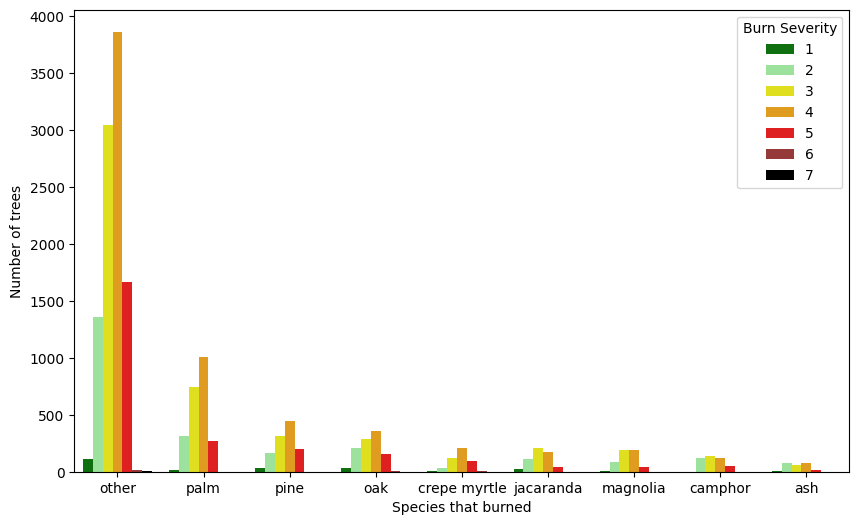

In [30]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# use the scatterplot() function
sns.barplot(
    x="category", # the x column
    y="species", # the y column
    hue="sum", # the third dimension (color)
    data=byseverity,# pass in the data
    palette=sns.color_palette(['green', 'lightgreen', 'yellow', 'orange', 'red', 'brown', 'black']),
    ax=ax
)

# Format with matplotlib commands
ax.set_xlabel("Species that burned")
ax.set_ylabel("Number of trees")
# Change legend labels
ax.legend(title='Burn Severity', loc='upper right')

In [42]:
burn = []

for index, row in trees_withburn.iterrows():
  if row['sum'] == 0:
    burn.append("N/A")
  elif row['sum'] == 1 | row['sum'] == 2| row['sum'] == 3:
    burn.append('Not burnt')
  else:
    burn.append('Burnt')

trees_withburn['dNBR_Classification'] = burn

In [61]:
from collections import Counter
Counter(burn)

Counter({'Burnt': 11718, 'Not burnt': 5106})

In [49]:
proportion_burn = trees_withburn.groupby(['dNBR_Classification','category'])['species'].count().reset_index().rename(columns={'species':'Count'})
proportion_burn

,dNBR_Classification,category,Count
0,Burnt,ash,176
1,Burnt,camphor,296
2,Burnt,crepe myrtle,346
3,Burnt,jacaranda,353
4,Burnt,magnolia,317
5,Burnt,oak,751
6,Burnt,other,7025
7,Burnt,palm,1608
8,Burnt,pine,841
9,Not burnt,ash,63


In [57]:
df_wide = proportion_burn.pivot(index='category', columns='dNBR_Classification', values='Count')

df_wide

dNBR_Classification,Burnt,Not burnt
category,,
ash,176,63
camphor,296,134
crepe myrtle,346,120
jacaranda,353,204
magnolia,317,191
oak,751,289
other,7025,3046
palm,1608,745
pine,841,311


In [58]:
df_wide['Total number of trees'] = df_wide['Burnt'] + df_wide['Not burnt']
df_wide['Proportion of trees that burnt'] = df_wide['Burnt'] / df_wide['Total number of trees']
df_wide

dNBR_Classification,Burnt,Not burnt,Total number of trees,Proportion of trees that burnt
category,,,,
ash,176,63,239,0.736402
camphor,296,134,430,0.688372
crepe myrtle,346,120,466,0.742489
jacaranda,353,204,557,0.633752
magnolia,317,191,508,0.624016
oak,751,289,1040,0.722115
other,7025,3046,10071,0.697547
palm,1608,745,2353,0.683383
pine,841,311,1152,0.730035
